## Welcome to Behavioral Cloning

### 1. Data Collection & Augmentation

In [17]:
import csv
import os
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from scipy import ndimage
import matplotlib.pyplot as plt
import random
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.02449408/28549024 bytes (8.6%5029888/28549024 bytes (17.67569408/28549024 bytes (26.510305536/28549024 bytes (36.1%13041664/28549024 bytes (45.7%15810560/28549024 bytes (55.4%18530304/28549024 bytes (64.9%21282816/28549024 bytes (74.5%23994368/28549024 bytes (84.0%26730496/28549024 bytes (93.6%28549024/28549024 bytes (100.0%)
  Done
File saved as /home/carnd/.imageio/ffmpeg/ffmpeg.linux64.


In [2]:
samples = []
csv_file = '/home/carnd/Data/driving_log.csv'
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
           samples.append(row)
        
print(len(samples))

10043


In [3]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [4]:
def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

In [12]:
def generator(samples, batch_size):
    num_samples = len(samples)
    correction = 0.22
    while True: # Loop forever so the generator never terminates
        #shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            measurements = []
            for batch_sample in batch_samples:
                for i in range(3):
                    current_path = '/home/carnd/Data/IMG/'+batch_sample[i].split('/')[-1]
                    image = ndimage.imread(current_path)
                    if (i == 0):
                        measurement = float(batch_sample[3])
                    if (i == 1):
                        measurement = float(batch_sample[3]) + correction
                    if (i == 2):
                        measurement = float(batch_sample[3]) - correction
                    images.append(image)
                    measurements.append(measurement)

            # trim image to only see section with road
            augmented_images, augmented_measurements = [],[]
            for image,measurement in zip(images,measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)
                
                augmented_images.append(augment_brightness_camera_images(image))
                augmented_measurements.append(measurement)
                
                augmented_images.append(add_random_shadow(image))
                augmented_measurements.append(measurement)
                
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

In [13]:
## Data Collection and Train/Test 80/20 Split

train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(len(train_samples))
print(len(validation_samples))

batch_size = 64
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)
ch, row, col = 160, 320, 3  # Trimmed image format

8034
2009


### A little bit of Data Exploration

Number of augmented training data
192816
Number of augmented validation data
48216
Number of training data per epoch
768
Number of validation data per epoch
768
Train samples length and types
8034
<class 'list'>
Validation samples length and types
2009
<class 'list'>
Types for train generator, images
<class 'generator'>
<class 'list'>
<class 'numpy.ndarray'>
Shapes of full training data set then of each training image
(768, 160, 320, 3)
(160, 320, 3)
Types for validation generator, images
<class 'generator'>
<class 'list'>
<class 'numpy.ndarray'>
Shapes of full validation data set then of each validation image
(768, 160, 320, 3)
(160, 320, 3)


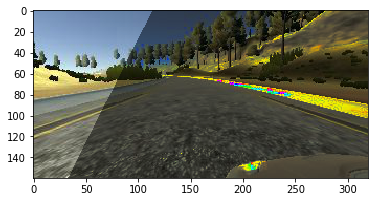

Corresponding angle
0.28312647


In [14]:
print("Number of augmented training data")
train_augmented = len(train_samples)*3*2*2*2
print(train_augmented)

print("Number of augmented validation data")
valid_augmented = len(validation_samples)*3*2*2*2
print(valid_augmented)

training_indice = random.randint(0, len(next(train_generator)[0]))
validation_indice = random.randint(0, len(next(validation_generator)[0]))

print("Number of training data per epoch")
print(len(next(train_generator)[0]))
print("Number of validation data per epoch")
print(len(next(validation_generator)[0]))

print("Train samples length and types")
print(len(train_samples))
print(type(train_samples))
print("Validation samples length and types")
print(len(validation_samples))
print(type(validation_samples))

print("Types for train generator, images")
print(type(train_generator))
print(type(next(train_generator)))
print(type(next(train_generator)[0]))

print("Shapes of full training data set then of each training image")
print(format(next(train_generator)[0].shape))
print(format(next(train_generator)[0][training_indice].shape))

print("Types for validation generator, images")
print(type(validation_generator))
print(type(next(validation_generator)))
print(type(next(validation_generator)[0]))

print("Shapes of full validation data set then of each validation image")
print(format(next(validation_generator)[0].shape))
print(format(next(validation_generator)[0][validation_indice].shape))


plt.imshow((next(train_generator)[0][training_indice]))
plt.show()
print("Corresponding angle")
print((next(train_generator)[1][training_indice]))

### 2. Model Definition and Training

In [9]:
##IMPORT LIBRARIES
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D

Using TensorFlow backend.


In [10]:
###GENERATOR TECHNIQUE PREPROCESSING
model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(ch, row, col),output_shape=(ch, row, col)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

#### Nvidia Team Model

In [11]:
##NVIDIA

model.add(Convolution2D(24,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="elu"))
model.add(Dropout(0.5))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(64,3,3,activation="elu"))
model.add(Convolution2D(64,3,3,activation="elu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

#### Fitting

In [15]:
from keras import optimizers

adam = optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=adam)
history_object = model.fit_generator(train_generator, samples_per_epoch= train_augmented, 
                                     validation_data=validation_generator, 
                                     nb_val_samples=valid_augmented, 
                                     nb_epoch=3, 
                                     verbose=1)

model.save('model.h5')

Epoch 1/3
192816/192816 [==============================] - 453s - loss: 0.0344 - val_loss: 0.0245
Epoch 2/3
192816/192816 [==============================] - 439s - loss: 0.0244 - val_loss: 0.0224
Epoch 3/3
192816/192816 [==============================] - 438s - loss: 0.0225 - val_loss: 0.0211


#### Visualizing the Loss

dict_keys(['loss', 'val_loss'])


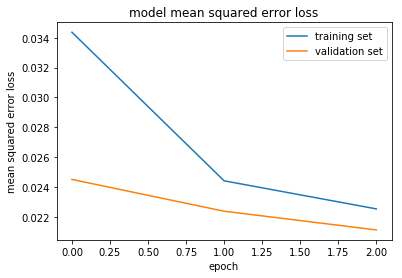

In [16]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()